In [ ]:
import tensorflow as tf
import pandas as pd
print(tf.__version__)

2.4.1


In [ ]:
series = pd.read_excel('Kamchatka1.xlsx')
series.head(10)

,Date,Час,Мин,Сек,Ошибка по времени,Широта,Ошибка по широте,Долгота,Ошибка по долготе,Глубина,Ошибка по глубине,Magnitude,Код сети,Сейсмический регион,Географический регион,Макросейсмические данные
0,2003-01-01,1,33,22.1,1.2,52.80,0.01,160.18,0.01,34,3.0,4.8,KAGSR,Камчатка и Командорские острова,NaN,Ощущалось на мысе\r\nШипунский силой 2 балла.
1,2003-01-01,3,41,7.8,0.4,53.70,0.03,160.81,0.03,36,5.0,3.0,KAGSR,Камчатка и Командорские острова,NaN,NaN
2,2003-01-01,10,30,51.4,0.7,54.96,0.03,161.02,0.03,87,3.0,2.8,KAGSR,Камчатка и Командорские острова,NaN,NaN
3,2003-01-01,14,57,50.2,0.8,51.25,0.13,153.40,0.13,287,13.0,3.6,KAGSR,Камчатка и Командорские острова,NaN,NaN
4,2003-01-03,5,30,32.8,0.4,55.59,0.11,165.93,0.11,19,12.0,3.6,KAGSR,Камчатка и Командорские острова,NaN,NaN
5,2003-01-03,7,53,24.1,0.6,54.11,0.14,169.33,0.14,21,17.0,2.9,KAGSR,Камчатка и Командорские острова,NaN,NaN
6,2003-01-03,8,5,5.3,0.6,53.05,0.02,160.55,0.02,37,3.0,3.3,KAGSR,Камчатка и Командорские острова,NaN,NaN
7,2003-01-04,2,5,5.3,0.5,50.72,0.04,157.42,0.04,40,10.0,3.1,KAGSR,Камчатка и Командорские острова,NaN,NaN
8,2003-01-04,11,32,34.3,0.6,55.39,0.04,166.45,0.04,24,3.0,2.9,KAGSR,Камчатка и Командорские острова,NaN,NaN
9,2003-01-04,13,46,16.3,0.5,49.38,0.14,156.32,0.14,64,31.0,3.2,KAGSR,Камчатка и Командорские острова,NaN,NaN


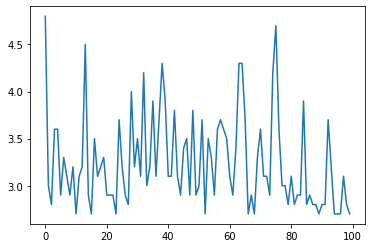

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
series = pd.read_excel('Kamchatka1.xlsx')

time = np.array(range(0,len(series['Date'])))
#time_1 = np.array(series['Date'])
Magnitude = np.array(series['Magnitude'])
#print(time)
plt.plot(time[:100],Magnitude[:100])
plt.show()

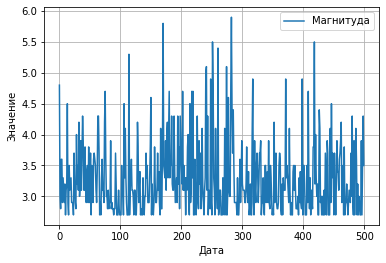

In [ ]:
import matplotlib.dates as mdates
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.plot(time[:500],Magnitude[:500],label="Магнитуда")
plt.legend(loc="upper right")
plt.grid()
plt.xlabel("Дата")
plt.ylabel("Значение")
plt.show()

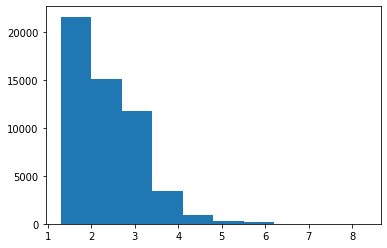

In [ ]:
#xaxis = np.array(range(5,10))
#print(xaxis)
#plt.bar(xaxis,series['Magnitude'])
#series['Magnitude'].plot(kind="hist",title = "Магнитуда")
plt.hist(series['Magnitude'],label = "Гистограмма")
plt.show()

In [ ]:
series['New'] = pd.to_datetime(series['Час']).astype(int) + pd.to_datetime(series['Мин']).astype(int) +pd.to_datetime(series['Сек']).astype(int)
series['New']

0         56
1         51
2         91
3        121
4         67
        ... 
53458    131
53459     77
53460     91
53461     66
53462     88
Name: New, Length: 53463, dtype: int64

In [ ]:
series.head(30)

,Date,Час,Мин,Сек,Ошибка по времени,Широта,Ошибка по широте,Долгота,Ошибка по долготе,Глубина,Ошибка по глубине,Magnitude,Код сети,Сейсмический регион,Географический регион,Макросейсмические данные
0,2003-01-01,1,33,22.1,1.2,52.80,0.01,160.18,0.01,34,3.0,4.8,KAGSR,Камчатка и Командорские острова,NaN,Ощущалось на мысе\r\nШипунский силой 2 балла.
1,2003-01-01,3,41,7.8,0.4,53.70,0.03,160.81,0.03,36,5.0,3.0,KAGSR,Камчатка и Командорские острова,NaN,NaN
2,2003-01-01,10,30,51.4,0.7,54.96,0.03,161.02,0.03,87,3.0,2.8,KAGSR,Камчатка и Командорские острова,NaN,NaN
3,2003-01-01,14,57,50.2,0.8,51.25,0.13,153.40,0.13,287,13.0,3.6,KAGSR,Камчатка и Командорские острова,NaN,NaN
4,2003-01-03,5,30,32.8,0.4,55.59,0.11,165.93,0.11,19,12.0,3.6,KAGSR,Камчатка и Командорские острова,NaN,NaN
5,2003-01-03,7,53,24.1,0.6,54.11,0.14,169.33,0.14,21,17.0,2.9,KAGSR,Камчатка и Командорские острова,NaN,NaN
6,2003-01-03,8,5,5.3,0.6,53.05,0.02,160.55,0.02,37,3.0,3.3,KAGSR,Камчатка и Командорские острова,NaN,NaN
7,2003-01-04,2,5,5.3,0.5,50.72,0.04,157.42,0.04,40,10.0,3.1,KAGSR,Камчатка и Командорские острова,NaN,NaN
8,2003-01-04,11,32,34.3,0.6,55.39,0.04,166.45,0.04,24,3.0,2.9,KAGSR,Камчатка и Командорские острова,NaN,NaN
9,2003-01-04,13,46,16.3,0.5,49.38,0.14,156.32,0.14,64,31.0,3.2,KAGSR,Камчатка и Командорские острова,NaN,NaN


In [ ]:
split_time = 52000
time_train = time[:split_time]
x_train = Magnitude[:split_time]
time_valid = time[split_time:]
x_valid = Magnitude[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 3000

In [ ]:
print(len(series['Date']))

53463


In [ ]:
def windowed_dataset(Magnitude, window_size, batch_size, shuffle_buffer):
    Magnitude = tf.expand_dims(Magnitude, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(Magnitude)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, Magnitude, window_size):
    ds = tf.data.Dataset.from_tensor_slices(Magnitude)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(60).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=180, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),   
  
   
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True), 
  #tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(45, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),  
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=50)

Epoch 1/50
289/289 [==============================] - 11s 29ms/step - loss: 7.8064 - mae: 8.2541
Epoch 2/50
289/289 [==============================] - 9s 29ms/step - loss: 0.4074 - mae: 0.7711
Epoch 3/50
289/289 [==============================] - 9s 30ms/step - loss: 0.3820 - mae: 0.7391
Epoch 4/50
289/289 [==============================] - 9s 29ms/step - loss: 0.3688 - mae: 0.7238
Epoch 5/50
289/289 [==============================] - 9s 29ms/step - loss: 0.3597 - mae: 0.7133
Epoch 6/50
289/289 [==============================] - 8s 28ms/step - loss: 0.3527 - mae: 0.7050
Epoch 7/50
289/289 [==============================] - 9s 29ms/step - loss: 0.3472 - mae: 0.6984
Epoch 8/50
289/289 [==============================] - 9s 30ms/step - loss: 0.3436 - mae: 0.6941
Epoch 9/50
289/289 [==============================] - 8s 29ms/step - loss: 0.3398 - mae: 0.6895
Epoch 10/50
289/289 [==============================] - 9s 29ms/step - loss: 0.3372 - mae: 0.6864
Epoch 11/50
289/289 [=================

In [ ]:
def plot_series(Date, Magnitude , start=0, end=None):
    plt.plot(Date[start:end], Magnitude[start:end], )
    plt.xlabel("Время")
    plt.ylabel("Значение")
    plt.grid(True)

In [ ]:
rnn_forecast = model_forecast(model, Magnitude[...,np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, -0]

In [ ]:
print(x_train)

[4.8 3.  2.8 ... 2.4 2.3 2.6]


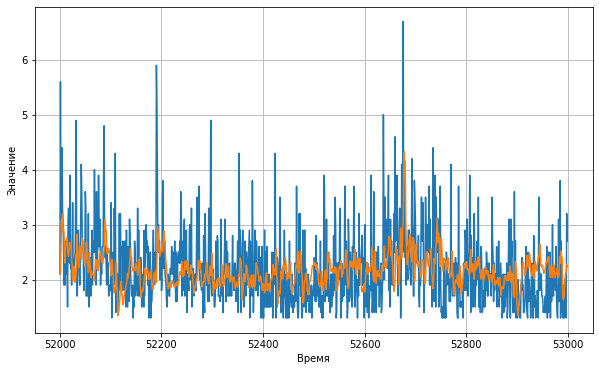

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid[:1000], x_valid[:1000])
plot_series(time_valid[:1000], rnn_forecast[:1000])

In [ ]:
print(rnn_forecast)

print(x_valid)

[2.2521448 2.346292  1.9205325 ... 2.316022  2.255625  2.0852706]
[2.1 5.6 3.1 ... 1.4 2.1 2.9]


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.5900322

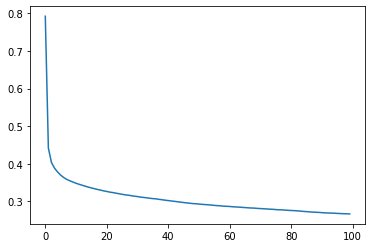

In [ ]:
plt.plot(history.epoch, history.history["loss"])
plt.show()

In [ ]:
print(history.history)

{'loss': [0.4575381278991699, 0.37338608503341675, 0.3245077133178711, 0.2910018563270569, 0.275409996509552, 0.26600542664527893, 0.2587117552757263, 0.2522142231464386, 0.24648907780647278, 0.24079082906246185, 0.23565663397312164, 0.2304273545742035, 0.22539503872394562, 0.22099484503269196, 0.2166183888912201, 0.21223248541355133, 0.20796312391757965, 0.20434492826461792, 0.20021606981754303, 0.1965913325548172, 0.19305770099163055, 0.18979229032993317, 0.1864350587129593, 0.18328402936458588, 0.17994993925094604, 0.17687617242336273, 0.1736821085214615, 0.17074023187160492, 0.1678476631641388, 0.16496039927005768, 0.1626530885696411, 0.16053278744220734, 0.15849421918392181, 0.15656185150146484, 0.15494070947170258, 0.1530768871307373, 0.15150956809520721, 0.14989085495471954, 0.14819447696208954, 0.14682945609092712, 0.14543679356575012, 0.14413386583328247, 0.14284366369247437, 0.14164602756500244, 0.1404423713684082, 0.1394408494234085, 0.13822399079799652, 0.13720813393592834,

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 50)          3050      
_________________________________________________________________
dense_1 (Dense)              (None, None, 25)          1275      
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           26        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

<Figure size 432x288 with 0 Axes>

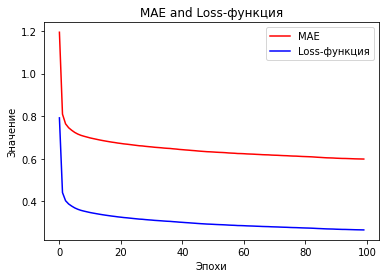

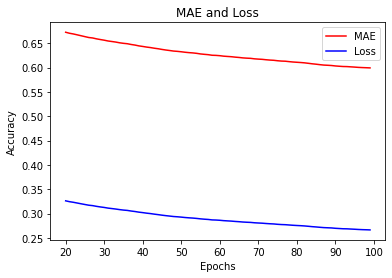

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) 


plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss-функция')
plt.xlabel("Эпохи")
plt.ylabel("Значение")
plt.legend(["MAE", "Loss-функция"])

plt.figure()

epochs_zoom = epochs[20:]
mae_zoom = mae[20:]
loss_zoom = loss[20:]


# Приближенные 

plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [ ]:
Magnitude=np.reshape(Magnitude,(23412,1,1))
model.predict(Magnitude[23385:23415][np.newaxis])